In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from scipy import signal
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
import matplotlib
from matplotlib import pyplot as plt
import gc



print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.7.0
Keras Version: 2.7.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.4
Scikit-Learn 1.0.1
GPU is available


Globals

In [2]:
cwd = os.getcwd()
FREQ = 256
database_path = 'Dataset/CHB-MIT/'
filtered_database_path = '../Dataset/CHB-MIT/Filtered-chb-mit/'
save_csv_path = "../DataSet/CHB-MIT/filtered_df_csv"
external_hardisk_drive_path = os.path.dirname('/Volumes/NHR HDD/CHB-MIT/')
csv_path = external_hardisk_drive_path + "/19-12-csv/"


In [3]:
def remove_cols(dataframe, col_start = 0, col_end = 0):
    if col_end == 0:
        col_end = len(dataframe.columns) - 1
    
    dataframe = dataframe.iloc[: , col_start: col_end]
    return dataframe

In [4]:
os.getcwd()

'/Users/niklashjort/Desktop/Notes/Speciale/projects/DataHandling/MIT_CHB/jupyter'

In [5]:
for f in os.listdir(csv_path):
    print(f)

Seizure
Preictal
Interictal


In [6]:
df = pd.read_csv(csv_path + "/" + "Seizure" + "/" + "chb22_25_sz_3139.csv", index_col=False)

In [7]:
df.columns

Index(['Unnamed: 0', 'class', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '--0',
       'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '--1', 'FZ-CZ', 'CZ-PZ', '--2',
       'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '--3', 'FP2-F8', 'F8-T8',
       'T8-P8-0', 'P8-O2', '--4', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8',
       'T8-P8-1'],
      dtype='object')

In [8]:
len(df)

18944

In [9]:
# print(test_df.info(memory_usage='deep'))
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [10]:
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18944 entries, 0 to 18943
Columns: 30 entries, Unnamed: 0 to T8-P8-1
dtypes: float64(29), int64(1)
memory usage: 4.3 MB


In [11]:
mem_usage(df)

'4.34 MB'

In [12]:
df.dtypes

Unnamed: 0      int64
class         float64
FP1-F7        float64
F7-T7         float64
T7-P7         float64
P7-O1         float64
--0           float64
FP1-F3        float64
F3-C3         float64
C3-P3         float64
P3-O1         float64
--1           float64
FZ-CZ         float64
CZ-PZ         float64
--2           float64
FP2-F4        float64
F4-C4         float64
C4-P4         float64
P4-O2         float64
--3           float64
FP2-F8        float64
F8-T8         float64
T8-P8-0       float64
P8-O2         float64
--4           float64
P7-T7         float64
T7-FT9        float64
FT9-FT10      float64
FT10-T8       float64
T8-P8-1       float64
dtype: object

In [13]:
df.head()

,Unnamed: 0,class,FP1-F7,F7-T7,T7-P7,P7-O1,--0,FP1-F3,F3-C3,C3-P3,...,FP2-F8,F8-T8,T8-P8-0,P8-O2,--4,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
0,803584,1.0,-1.191697e-05,-1.035409e-05,-0.000055,-0.000006,0.0,-0.000028,-0.000035,-0.000027,...,0.000003,-0.000012,1.953602e-07,-0.000012,0.0,0.000056,0.000019,0.000024,-0.000007,1.953602e-07
1,803585,1.0,-9.963370e-06,-1.074481e-05,-0.000053,-0.000013,0.0,-0.000031,-0.000031,-0.000031,...,0.000008,-0.000016,6.837607e-06,-0.000007,0.0,0.000053,0.000024,0.000021,-0.000012,6.837607e-06
2,803586,1.0,-3.711844e-06,-1.230769e-05,-0.000053,-0.000019,0.0,-0.000029,-0.000029,-0.000032,...,0.000008,-0.000015,3.711844e-06,0.000003,0.0,0.000053,0.000029,0.000014,-0.000012,3.711844e-06
3,803587,1.0,-2.539683e-06,-3.711844e-06,-0.000055,-0.000025,0.0,-0.000028,-0.000025,-0.000031,...,0.000012,-0.000011,3.321123e-06,0.000012,0.0,0.000056,0.000021,0.000008,-0.000008,3.321123e-06
4,803588,1.0,-9.768010e-07,-5.860806e-07,-0.000045,-0.000027,0.0,-0.000028,-0.000019,-0.000029,...,0.000014,-0.000006,5.665446e-06,0.000020,0.0,0.000045,0.000016,0.000005,-0.000004,5.665446e-06


In [14]:
df.columns

Index(['Unnamed: 0', 'class', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '--0',
       'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '--1', 'FZ-CZ', 'CZ-PZ', '--2',
       'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '--3', 'FP2-F8', 'F8-T8',
       'T8-P8-0', 'P8-O2', '--4', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8',
       'T8-P8-1'],
      dtype='object')

In [15]:
def downcast_dtypes(df):
    _start = df.memory_usage(deep=True).sum() / 1024 ** 2
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    _end = df.memory_usage(deep=True).sum() / 1024 ** 2
    saved_time = (_start - _end) / _start * 100
    #print(f"Saved: {saved_time:.2f}%")
    return df

In [16]:
df = downcast_dtypes(df)

In [17]:
df['class'].value_counts()

1.0    18944
Name: class, dtype: int64

In [18]:
df['class'] = df['class'].astype('int32')

In [29]:
def get_window(channel, start_index, data, size = 4, overlap = 0, is_sezure = False, frequency = 256):
    if(is_sezure):
        overlap = 2
    else:
        overlap = overlap
    
    start = start_index * (size - overlap) * frequency
    end = start + (size * frequency)

    return data[channel][start:end].tolist()

In [20]:
def get_max_window_iteration(dataframe, buffer):
    len_of_df = int(len(dataframe) // (buffer*FREQ))
    return len_of_df


In [46]:

def butter_highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.lfilter(b, a, data)
    return y

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    i, u = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(i, u, data)
    return y

def apply_filter(series, FREQ):
    series = butter_bandstop_filter(series, 97, 103, FREQ, order=6)
    series = butter_bandstop_filter(series, 47, 53, FREQ, order=6)
    series = butter_highpass_filter(series, 1, FREQ, order=6)
    return series

In [57]:
Fs = 256            # Define the sampling frequency,
interval = Fs        # ... the interval size,
overlap = int(interval*0.95)  # ... and the overlap intervals

def spec_transform_save_to_folder(index, win, channel, patient_state, patient, plot_title = False):
    plt.figure(figsize=(7,7))
    series = win
    try:
        series = np.array(series).astype(np.float)
    except Exception as e:
        print(f"error: {e}")
        print(f"patient_state: {patient_state} channel: {channel} index: {index} window: {series}")
    denoised_series = denoise_wavelet(series, method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=3)
    if plot_title:
        plt.title(f"{channel} : is_seizure = {patient_state}")

    series = apply_filter(series, Fs)

    f, t, Sxx = signal.spectrogram(series, fs=256, nfft=1024, nperseg=256, noverlap=overlap, window='hann')
                         
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='jet')



    #s,f,t,im = plt.specgram(denoised_series,Fs=256)
    #plt.ylim(0, 20)
    #plt.axis('off')
    
    # f, t, Sxx = signal.spectrogram(denoised_series, 1./FREQ, nfft=overlap, nperseg=int(256/2))
    # #plt.pcolormesh(t, f[0:20], Sxx[0:20])
    # plt.pcolormesh(t, f, 10*np.log10(Sxx))
    plt.show()
    # if patient_state == "seizure":
    #     plt.savefig(f'test_data//windows/Seizure2/{patient}_{index}_{channel}_{time_of_observation}.png', edgecolor='none', bbox_inches='tight')
    # elif patient_state == "interictal":
    #     plt.savefig(f'test_data//windows/Interictal/{patient}_{index}_{channel}_{time_of_observation}.png')
    # elif patient_state == "prei_one":
    #     plt.savefig(f'test_data//windows/test/Preictal_One/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    # elif patient_state == "prei_two":
    #     plt.savefig(f'test_data/windows/Preictal_Two/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    # plt.show()
    del series
    plt.clf()    
    plt.close()
    gc.collect()

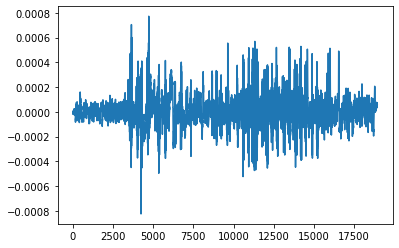

In [22]:
plt.plot(df['FP1-F7'])

In [23]:
#from spectrogram_proj.spectrogram import multitaper_spec_save_to_folder, spec_save_to_folder, nanpow2db

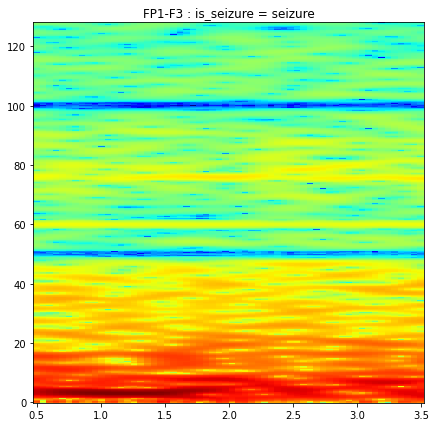

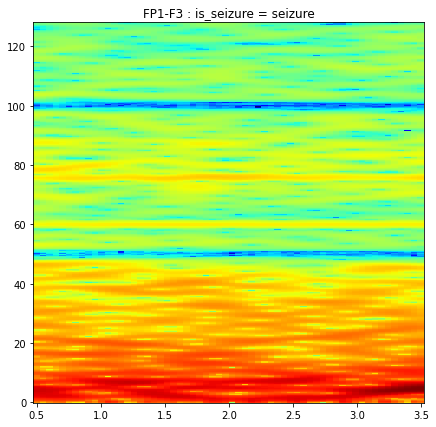

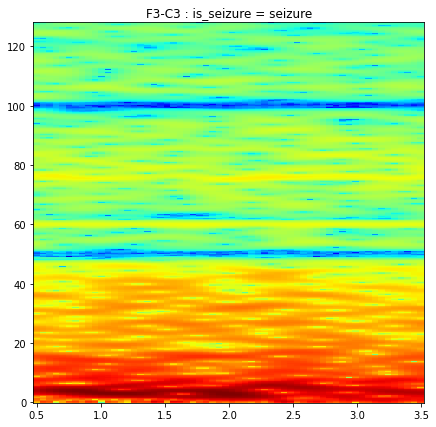

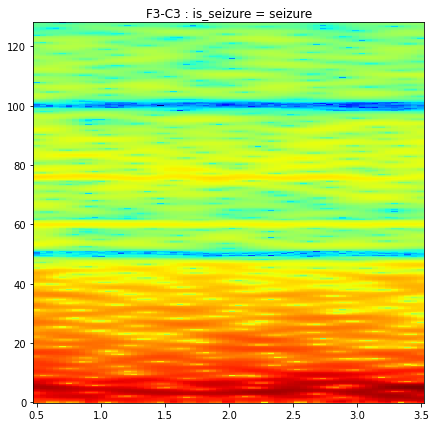

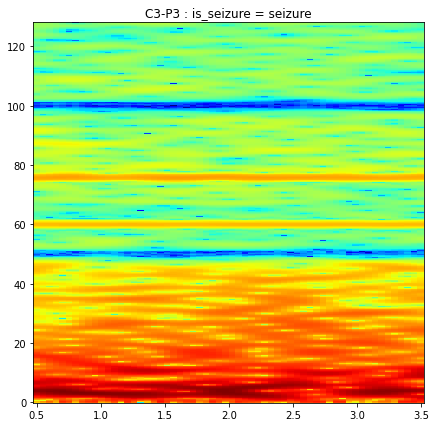

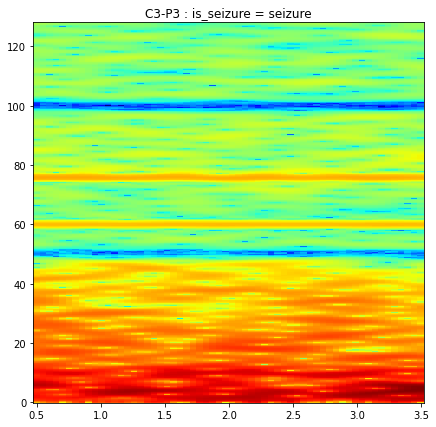

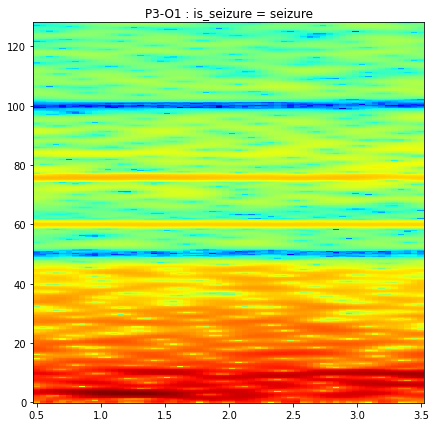

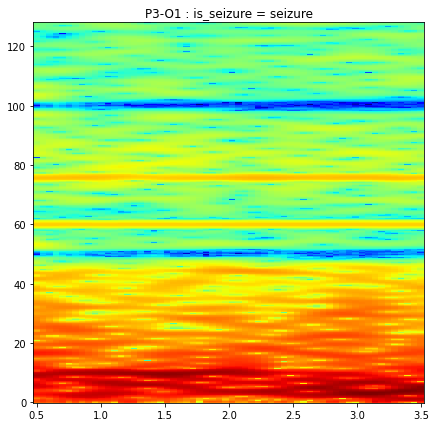

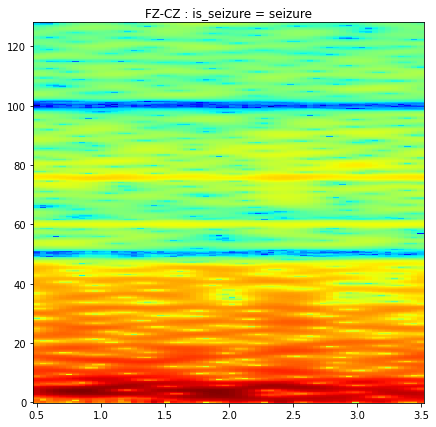

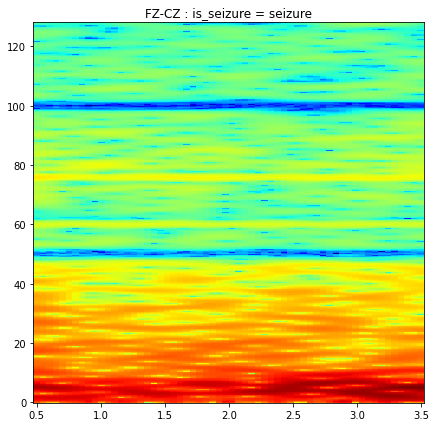

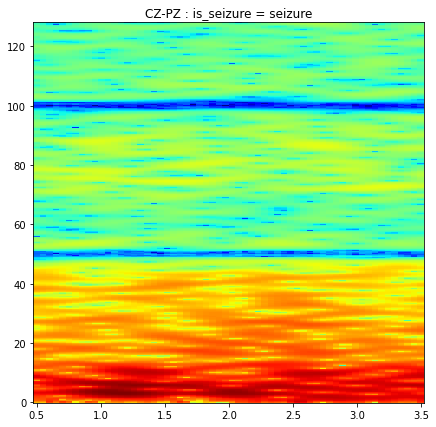

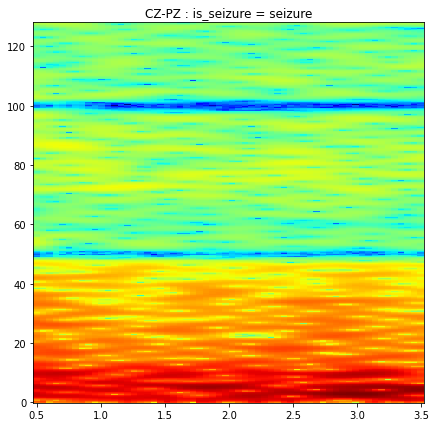

In [58]:
count = 0


int_count = 0
prei_count = 0

sz_win = []
inter_win =[]
for channel in ['FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1','FZ-CZ', 'CZ-PZ']:
    count = 0
    sz_count = 0
    if count < 1:
        if len(df) > 0 and df.empty == False and sz_count < 3:
            sz_win = [get_window(channel=channel, start_index=i, data=df, is_sezure=True) for i in range(get_max_window_iteration(df, 2))]
            for index, window in enumerate(sz_win):
                if sz_count > 1:continue
                sz_count += 1
                spec_transform_save_to_folder(channel=channel, index=index, win=window, patient_state="seizure", patient="bla", plot_title=True)
            
        count += 1


#del sz, prei_one, inter, df

In [25]:

gc.collect()

99

In [26]:
multitaper_spec_save_to_folder(channel="bla", patient=5, patient_state="hi", save_path="", index=1, win=sz_win[10])

NameError: name 'multitaper_spec_save_to_folder' is not defined

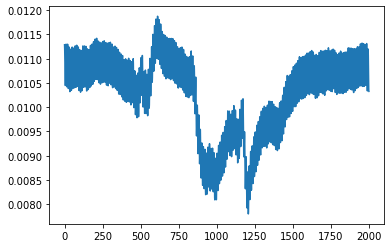

In [ ]:
plt.plot(sz_win[16][0])

In [ ]:
# from mne.time_frequency import psd_array_multitaper
# f, ax = plt.subplots()
# psd_mt, freqs_mt = psd_array_multitaper(np.array(sz_win[16][0]), 500, adaptive=True,
#                                             normalization='full', verbose=0)

# # get mean and sd
# psds_mean = psd_mt.mean(0).mean(0)
# psds_std = psd_mt.mean(0).std(0)
# # plot results
# ax.plot(freqs_mt, psds_mean, color='k')
# ax.fill_between(freqs_mt, psds_mean - psds_std, psds_mean + psds_std,
#                 color='k', alpha=.5)
# plt.show()

In [ ]:
#psd_mt = nanpow2db(psd_mt)

In [ ]:
# sc = 'slategrey'
# plt.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")

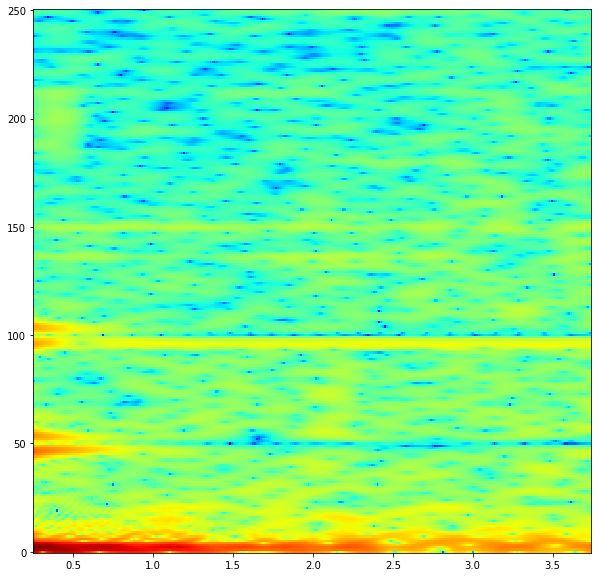

SUCCES - patient: 5 time: 20-56-48


In [ ]:
plt.figure(figsize=(10,10))
sys.path.append("/Users/niklashjort/Desktop/Notes/Speciale/projects/DataHandling/Køge/")
from spectrogram_proj.spectrogram import multitaper_spec_save_to_folder, spec_save_to_folder, nanpow2db
spec_save_to_folder(channel="bla", patient=5, patient_state="hi", save_path="", index=1, win=sz_win[10])

In [ ]:
len(sz_win)

19

In [ ]:
sze = sz_win[10][0]
inte = inter_win[100][0]

IndexError: list index out of range

In [ ]:
time = np.arange(len(inte))/500
time

array([0.000e+00, 2.000e-03, 4.000e-03, ..., 3.994e+00, 3.996e+00,
       3.998e+00])

In [ ]:
nyquist = 500 / 2.
b, a = signal.filter_design.iirfilter(3, (120. / nyquist, 121. / nyquist), rs=10,
                               ftype='cheby2')

In [ ]:
xfilt = signal.filtfilt(b, a, sz)

NameError: name 'sz' is not defined

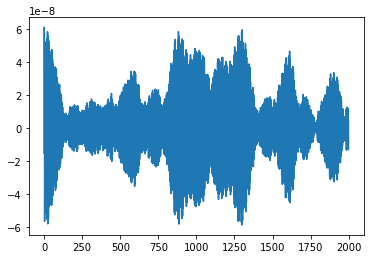

In [ ]:
plt.plot(xfilt)

In [ ]:
win = 4 * 256
f, psd = signal.welch(sz,
               fs=1./256,  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant') # detrend x by subtracting the mean

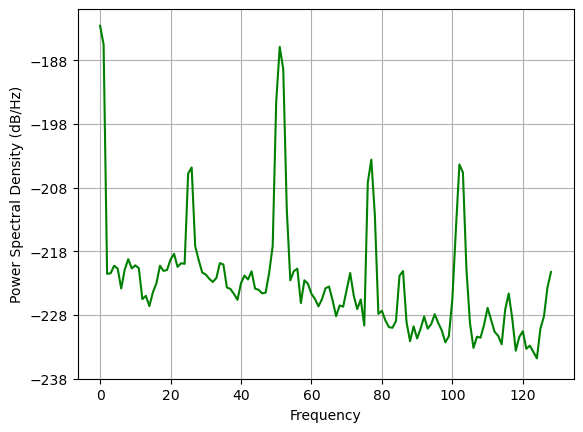

In [ ]:
plt.style.use('default')
plt.psd(np.array(sz)**2, Fs=256, color ="green")
lines = plt.gca().get_lines()
x_data = lines[0].get_data()[1]

In [ ]:
den_sz = denoise_wavelet(np.array(sze).astype(np.float),wavelet='db8', method='BayesShrink', mode='hard',rescale_sigma=True, multichannel=False, wavelet_levels=3)
den_inte = denoise_wavelet(np.array(inte).astype(np.float),wavelet='db8', method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=3)


In [ ]:
Fs = 256         # Define the sampling frequency,
interval = 256       # ... the interval size,
overlap = interval * 0.99  # ... and the overlap intervals

/usr/local/Caskroom/miniforge/base/envs/speciale_01_01/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


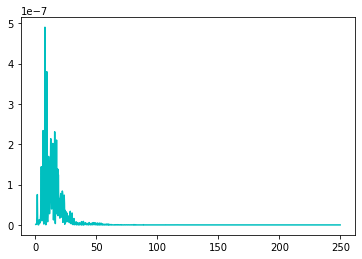

In [ ]:
dt = 1/500
highpass2 = butter_highpass_filter(inte, cutoff, 500, order=6)
n = len(highpass2)
fhat = np.fft.fft(highpass2, n)
PSD = fhat * np.conj(fhat / n)
freq = (1/(dt*n)) * np.arange(n)
L = np.arange(1, np.floor(n/2), dtype='int')

plt.plot(freq[L], PSD[L], color='c')

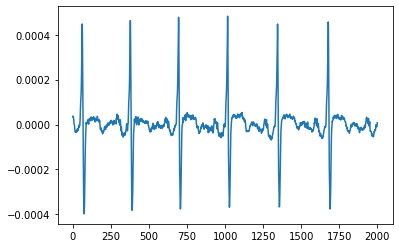

In [ ]:
plt.plot(highpass2)

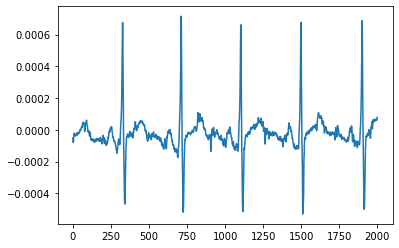

In [ ]:
plt.plot(sze)
#plt.plot(den_inte)

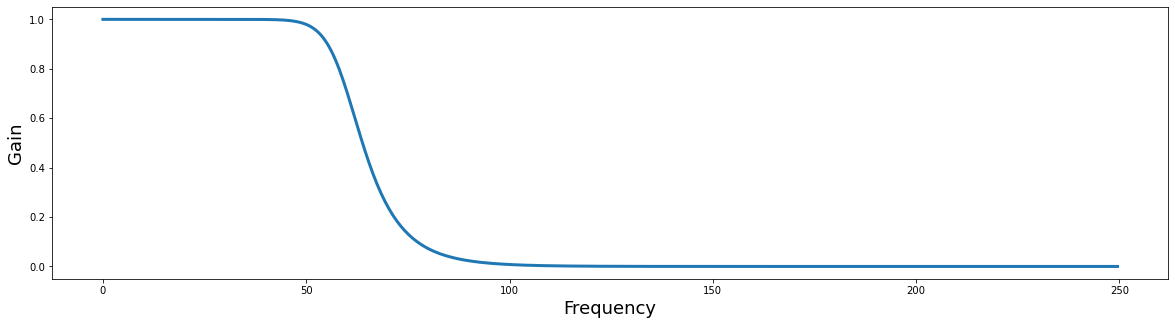

In [ ]:
filter_order = 8
frequency_cutoff = 60
sampling_frequency = 500

def rad_sample_to_hz(x, fs):
    return (x*fs)/(2*np.pi)

def plot_filter(b, a, fs):
    plt.figure(figsize=(20,5))
    w, h = signal.freqz(b, a, worN=256*2, whole=False)
    plt.plot(rad_sample_to_hz(w, fs), abs(h), linewidth=3)
    plt.ylabel('Gain', fontsize=18)
    plt.xlabel('Frequency', fontsize=18)

# Create the filter
b, a = signal.butter(8, frequency_cutoff, btype='low', output='ba', fs=sampling_frequency)
plot_filter(b, a, sampling_frequency)

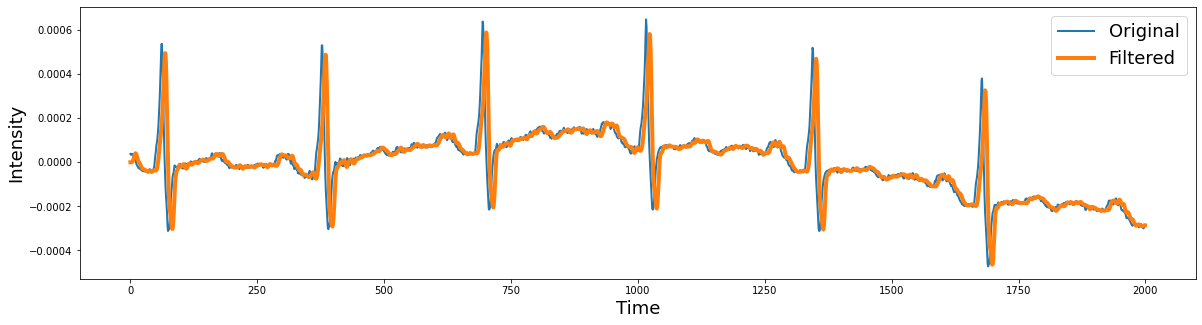

In [ ]:
# Apply the filter
filtered_int = signal.lfilter(b, a, inte)
filtered_sz = signal.filtfilt(b, a, sze)

plt.figure(figsize=(20,5))
plt.plot(inte, linewidth=2)
plt.plot(filtered_int, linewidth=4)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

In [ ]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.lfilter(b, a, data)
    return y

In [ ]:
lowpass = butter_lowpass_filter(sze, 60, 500, order=6)

In [ ]:
# Filtro taglia banda, passa alta
def butter_highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.lfilter(b, a, data)
    return y

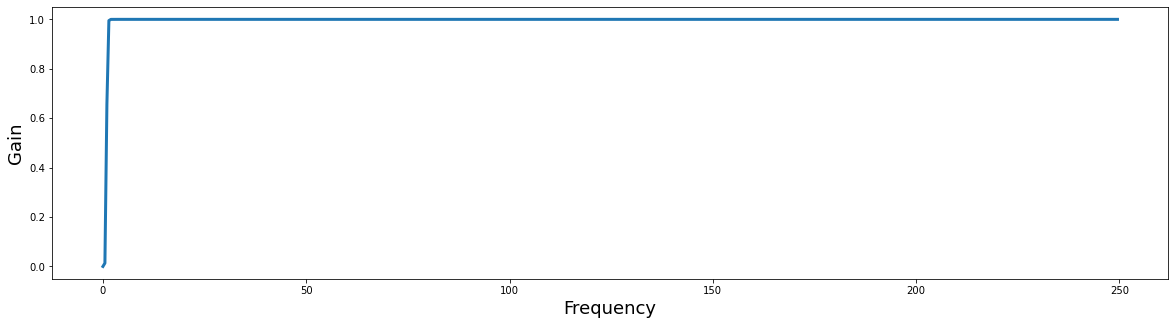

In [ ]:
b, a = signal.butter(6, 1, btype='high', analog=False, fs=500)
plot_filter(b, a, 500)
cutoff=1
highpass = butter_highpass_filter(sze, cutoff, 500, order=6)

In [ ]:
import matplotlib.pyplot as plt
from importlib import reload
import scipy
plt=reload(plt)

In [ ]:
def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    i, u = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(i, u, data)
    return y

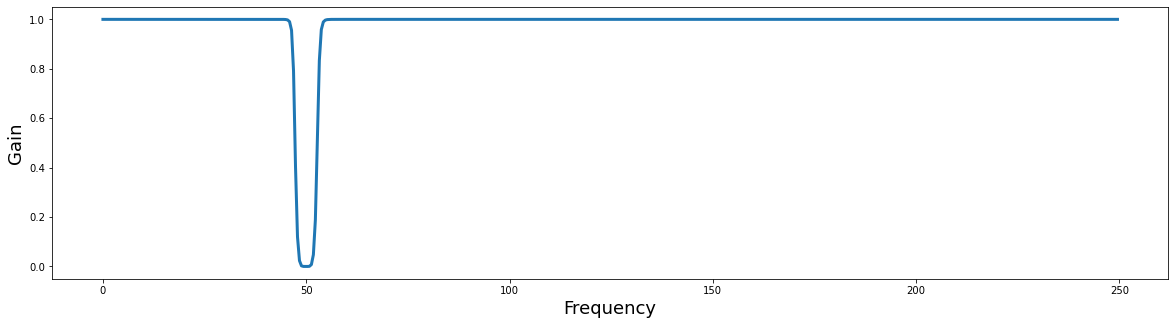

In [ ]:
b, a = signal.butter(6, [47, 53], btype='bandstop', output='ba', fs=FREQ)
plot_filter(b, a, sampling_frequency)

In [ ]:
lowcut=47
highcut=53

band_pass_50 = butter_bandstop_filter(sze, lowcut, highcut, FREQ, order=6)

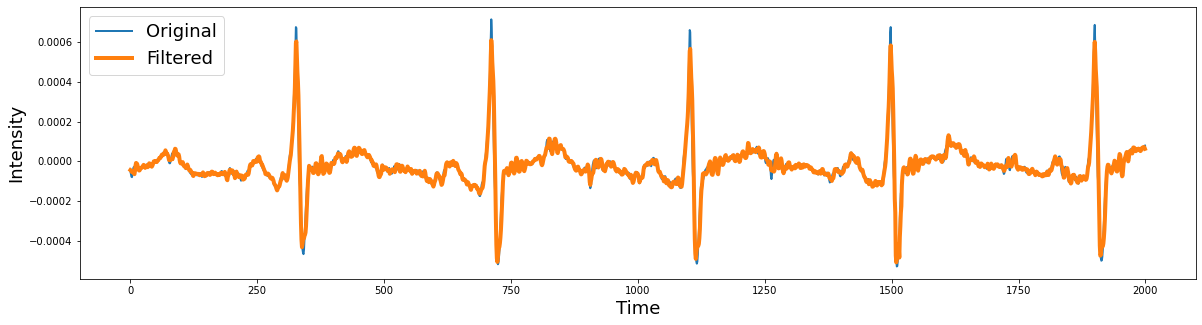

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(sze, linewidth=2)
plt.plot(band_pass_50, linewidth=4)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

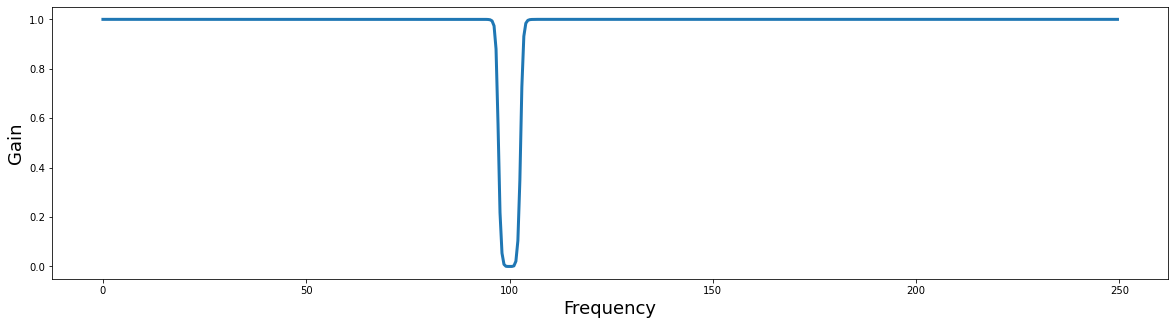

In [ ]:
b, a = signal.butter(6, [97, 103], btype='bandstop', output='ba', fs=FREQ)
plot_filter(b, a, sampling_frequency)

Text(0, 0.5, 'Hz')

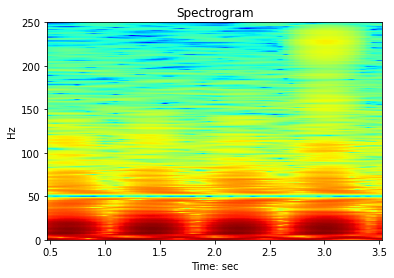

In [ ]:

s,f,t,im = plt.specgram(band_pass_50,Fs=500,cmap='jet', NFFT=int(500), noverlap=int(500*0.95))
plt.title("Spectrogram")
plt.xlabel("Time: sec")
plt.ylabel("Hz")


In [ ]:
band_pass_100 = butter_bandstop_filter(sze, 97, 103, FREQ, order=6)

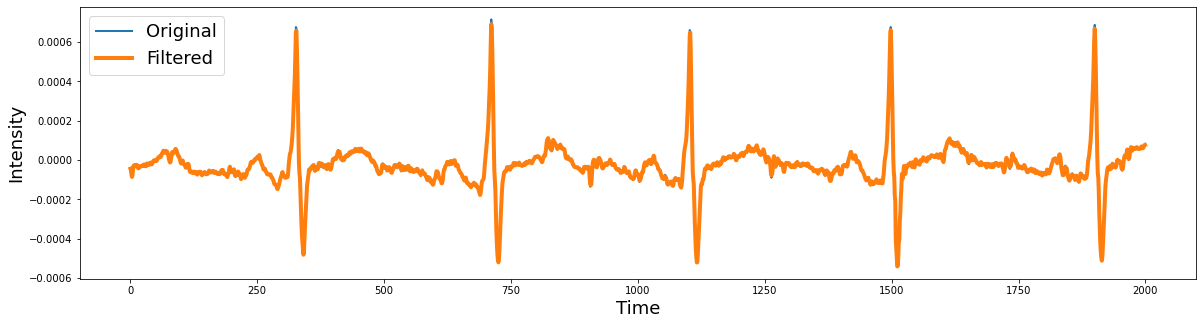

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(sze, linewidth=2)
plt.plot(band_pass_100, linewidth=4)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

In [ ]:
all = butter_bandstop_filter(sze, 97, 103, FREQ, order=6)
all = butter_bandstop_filter(all, 47, 53, FREQ, order=6)
all = butter_highpass_filter(all, 1, FREQ, order=6)

In [ ]:
all_low = butter_bandstop_filter(sze, 97, 103, FREQ, order=6)
all_low = butter_bandstop_filter(all_low, 47, 53, FREQ, order=6)
all_low = butter_highpass_filter(all_low, 1, FREQ, order=6)
all_low = butter_lowpass_filter(all_low, 60, 500, order=6)

In [ ]:
highpass_sz = butter_highpass_filter(sze, cutoff, 500, order=6)
highpass_inte = butter_highpass_filter(inte, cutoff, 500, order=6)

Text(0, 0.5, 'Hz')

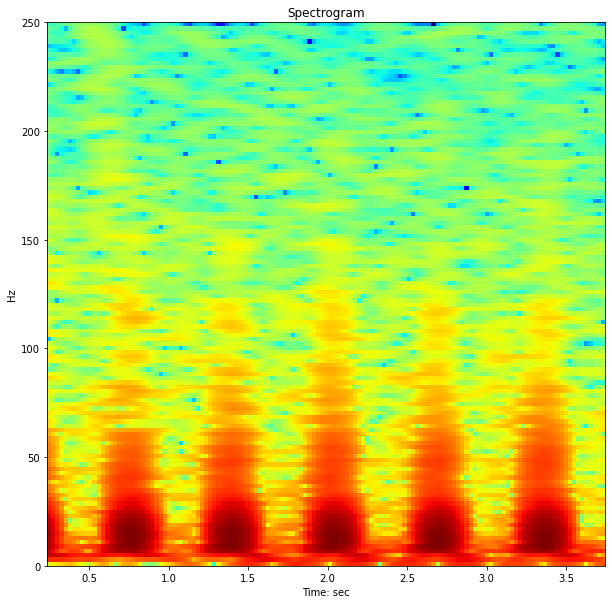

In [ ]:
plt.figure(figsize=(10, 10))
s,f,t,im = plt.specgram(highpass_inte, Fs=500,cmap='jet', NFFT=int(250), noverlap=int(250*0.95))
#plt.ylim(0,120)
plt.title("Spectrogram")
plt.xlabel("Time: sec")
plt.ylabel("Hz")

In [ ]:
s.shape

(251, 31)

In [ ]:
y = s[:120]
y.shape

(120, 7)

NameError: name 'axs' is not defined

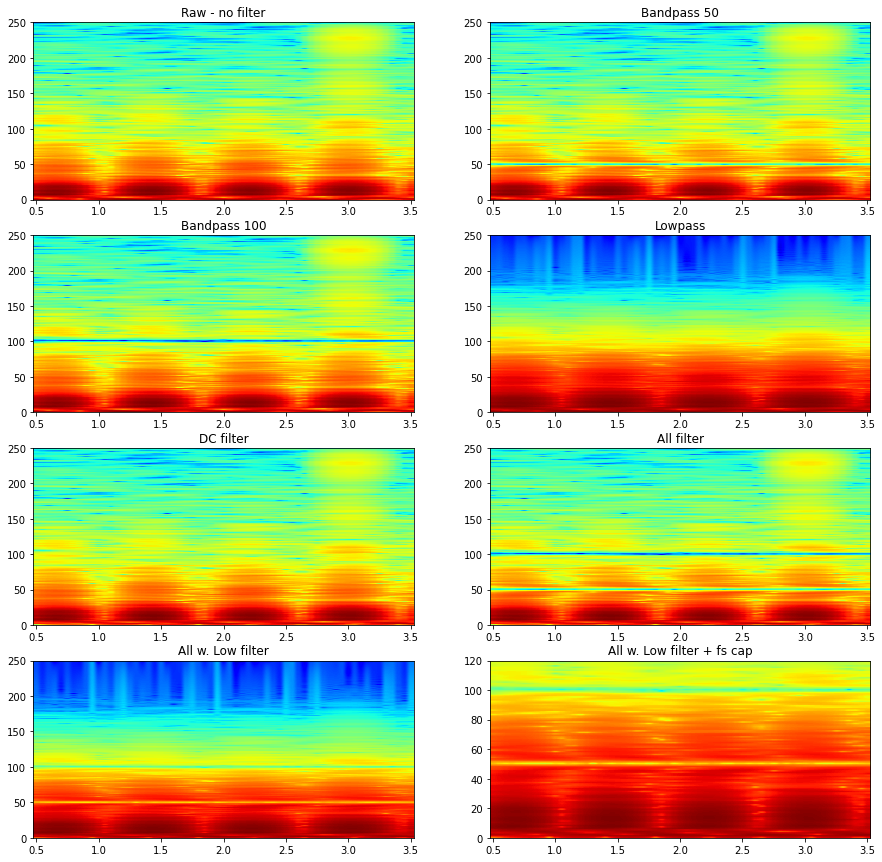

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15,15), sharey=False, sharex = False)
Pxx, freqs, bins, im = ax1.specgram(sze, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax1.set_title('Raw - no filter')
Pxx, freqs, bins, im = ax2.specgram(band_pass_50, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax2.set_title('Bandpass 50')
Pxx, freqs, bins, im = ax3.specgram(band_pass_100, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax3.set_title('Bandpass 100')
Pxx, freqs, bins, im = ax4.specgram(lowpass, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax4.set_title('Lowpass')
Pxx, freqs, bins, im = ax5.specgram(highpass, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax5.set_title('DC filter')
Pxx, freqs, bins, im = ax6.specgram(all, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax6.set_title('All filter')
Pxx, freqs, bins, im = ax7.specgram(all_low, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax7.set_title('All w. Low filter')
Pxx, freqs, bins, im = ax8.specgram(all_low, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet', scale_by_freq=False)
ax8.axis(ymin=0, ymax=120)
ax8.set_title('All w. Low filter + fs cap')


for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Hz')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
all_inte = butter_bandstop_filter(inte, 97, 103, FREQ, order=6)
all_inte = butter_bandstop_filter(all_inte, 47, 53, FREQ, order=6)
all_inte = butter_highpass_filter(all_inte, 1, FREQ, order=6)

In [ ]:
den_sz = denoise_wavelet(np.array(sze).astype(np.float),wavelet='db6', method='BayesShrink', mode='hard',rescale_sigma=True, multichannel=False, wavelet_levels=1)
den_inte = denoise_wavelet(np.array(inte).astype(np.float),wavelet='db6', method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=1)

all_den_sz = butter_bandstop_filter(den_sz, 97, 103, FREQ, order=6)
all_den_sz = butter_bandstop_filter(all_den_sz, 47, 53, FREQ, order=6)
all_den_sz = butter_highpass_filter(all_den_sz, 1, FREQ, order=6)

all_den_inte = butter_bandstop_filter(den_inte, 97, 103, FREQ, order=6)
all_den_inte = butter_bandstop_filter(all_den_inte, 47, 53, FREQ, order=6)
all_den_inte = butter_highpass_filter(all_den_inte, 1, FREQ, order=6)

all_low_sz = butter_bandstop_filter(sze, 97, 103, FREQ, order=6)
all_low_sz = butter_bandstop_filter(all_low_sz, 47, 53, FREQ, order=6)
all_low_sz = butter_highpass_filter(all_low_sz, 1, FREQ, order=6)
all_low_sz = butter_lowpass_filter(all_low_sz, 100, 500, order=1)

all_low_inte = butter_bandstop_filter(inte, 97, 103, FREQ, order=6)
all_low_inte = butter_bandstop_filter(all_low_inte, 47, 53, FREQ, order=6)
all_low_inte = butter_highpass_filter(all_low_inte, 1, FREQ, order=6)
all_low_inte = butter_lowpass_filter(all_low_inte, 100, 500, order=1)

Text(0.5, 1.0, 'low all int')

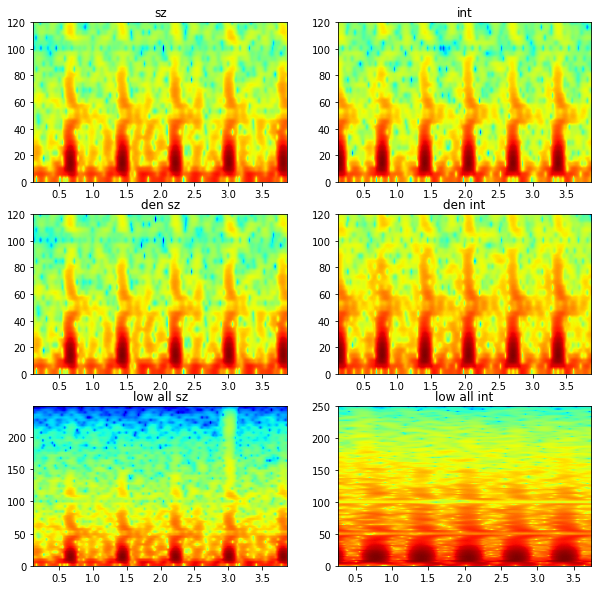

In [ ]:
nft = int(FREQ/4)
nover = int(nft*0.95)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10,10), sharey=False, sharex = False)
Pxx, freqs, bins, im = ax1.specgram(all, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax1.set_title('sz')
ax1.axis(ymin=0, ymax=120)
Pxx, freqs, bins, im = ax2.specgram(all_inte, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax2.set_title('int')
ax2.axis(ymin=0, ymax=120)

Pxx, freqs, bins, im = ax3.specgram(all_den_sz, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax3.set_title('den sz')
ax3.axis(ymin=0, ymax=120)
Pxx, freqs, bins, im = ax4.specgram(all_den_inte, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax4.set_title('den int')
ax4.axis(ymin=0, ymax=120)

Pxx, freqs, bins, im = ax5.specgram(all_low_sz, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax5.set_title('low all sz')
#ax5.axis(ymin=0, ymax=120)
Pxx, freqs, bins, im = ax6.specgram(all_low_inte, NFFT=256, Fs=500, noverlap=int(256*0.99), cmap='jet')
ax6.set_title('low all int')
#ax6.axis(ymin=0, ymax=120)




In [ ]:
Fs = 500       # Define the sampling frequency,
interval = 500   # ... the interval size,
overlap = interval * 0.95  # ... and the overlap intervals

/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_42062/142312461.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, Sxx, norm=normalize_color, cmap='jet')# Plot the result


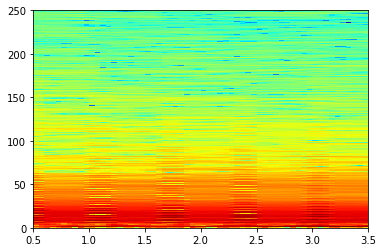

In [ ]:
import matplotlib
import pylab
import matplotlib.colors as colors
from scipy.stats import lognorm

f, t, Sxx = signal.spectrogram(np.array(inte), fs=Fs, nperseg=interval, noverlap=overlap)

normalize_color= colors.LogNorm(vmin=np.amin(Sxx), vmax=np.amax(Sxx))
plt.pcolormesh(t, f, Sxx, norm=normalize_color, cmap='jet')# Plot the result
#plt.savefig("hi2.png")


/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_42062/2612149833.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.abs(Zxx), cmap='jet')# Plot the result


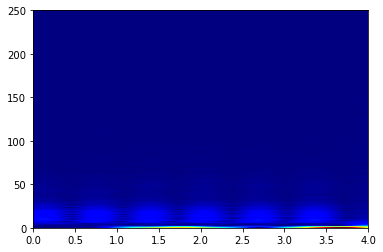

In [ ]:
f, t, Zxx = signal.stft(den_inte, fs=Fs, nperseg=FREQ, noverlap=FREQ*0.99)
plt.pcolormesh(t, f, np.abs(Zxx), cmap='jet')# Plot the result

(array([[1.82634458e-14, 2.43858444e-11, 1.93038613e-13, ...,
         1.80420771e-09, 7.10619752e-09, 1.17780430e-08],
        [2.44816024e-11, 2.47529225e-11, 2.30427937e-12, ...,
         9.23246145e-10, 3.83725839e-09, 5.50935903e-09],
        [2.71620877e-10, 8.21129120e-11, 1.21408186e-10, ...,
         3.24486042e-12, 7.41842519e-11, 5.07954058e-11],
        ...,
        [1.68169172e-15, 3.48714987e-14, 1.35041172e-15, ...,
         9.19514395e-15, 3.18723511e-16, 1.27356164e-15],
        [2.83001821e-15, 3.07883498e-14, 4.24513666e-16, ...,
         7.45650606e-15, 6.46863618e-15, 9.83745765e-15],
        [1.30221218e-15, 1.63301489e-14, 1.34902352e-16, ...,
         3.83779051e-15, 3.56579983e-16, 6.86874107e-15]]),
 array([  0.      ,   1.953125,   3.90625 ,   5.859375,   7.8125  ,
          9.765625,  11.71875 ,  13.671875,  15.625   ,  17.578125,
         19.53125 ,  21.484375,  23.4375  ,  25.390625,  27.34375 ,
         29.296875,  31.25    ,  33.203125,  35.15625 ,  37.1

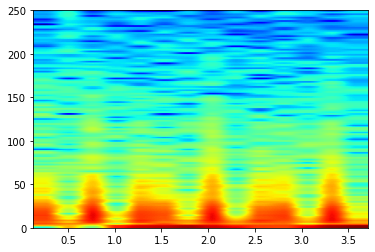

In [ ]:
plt.specgram(inte, cmap='jet', Fs=500)
#plt.savefig("hi.png")

In [ ]:
def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    i, u = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(i, u, data)
    return y

In [ ]:
fs=256
lowcut=117
highcut=123
y=butter_bandstop_filter(den_sz, lowcut, highcut, fs, order=6)

lowcut=57
highcut=63
y=butter_bandstop_filter(y, lowcut, highcut, fs, order=6)

In [ ]:
freqs, bins,Pxx =signal.spectrogram(y, nfft=256, fs=256, return_onesided=True, noverlap=256*0.95)

In [ ]:
Pxx = np.delete(Pxx, np.s_[117:123+1], axis=0)
Pxx = np.delete(Pxx, np.s_[57:63+1], axis=0)
Pxx = np.delete(Pxx, 0, axis=0)

In [ ]:
freqs = np.arange(Pxx.shape[0])

/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_8701/1495177456.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(freqs, bins, 10*np.log10(np.transpose(Pxx)),cmap=plt.cm.jet)


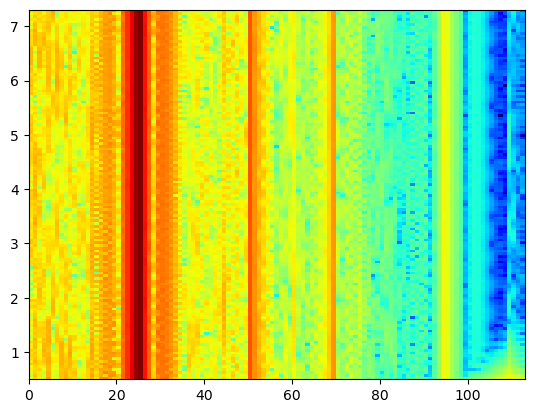

In [ ]:
plt.pcolormesh(freqs, bins, 10*np.log10(np.transpose(Pxx)),cmap=plt.cm.jet)

In [ ]:
result=(10*np.log10(np.transpose(Pxx))-(10*np.log10(np.transpose(Pxx))).min())/(10*np.log10(np.transpose(Pxx))).ptp()

/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_8701/42712137.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(freqs, bins, result,cmap=plt.cm.jet)


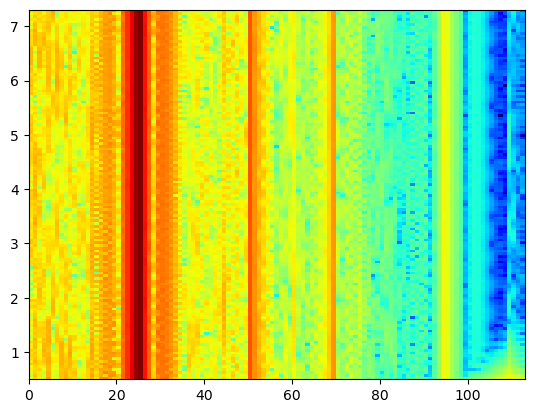

In [ ]:
freqs = np.arange(result.shape[1])
plt.pcolormesh(freqs, bins, result,cmap=plt.cm.jet)

In [ ]:
plt.style.use('default')
plt.specgram(filtered, Fs=256, NFFT=128, noverlap=256/8, cmap='jet')


NameError: name 'filtered' is not defined

In [ ]:
datetime.fromtimestamp(-2208984384000/1000).strftime('%H:%M:%S')

'02:13:36'

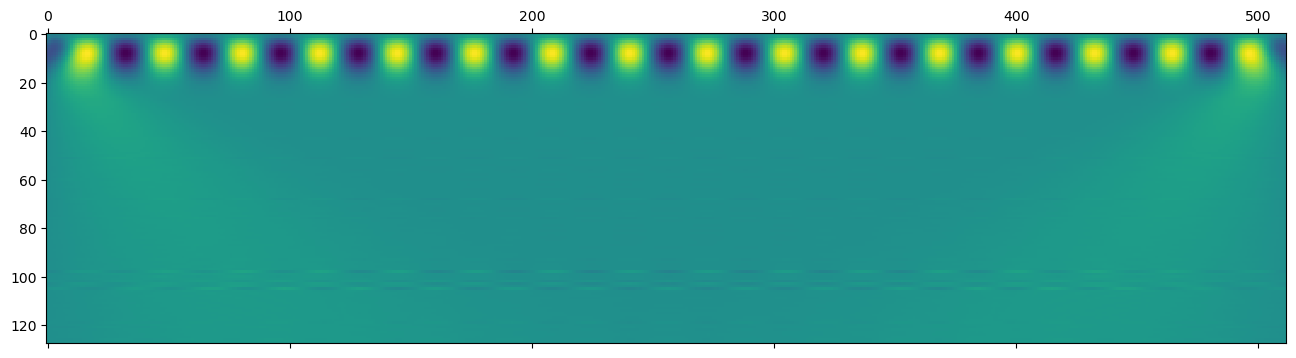

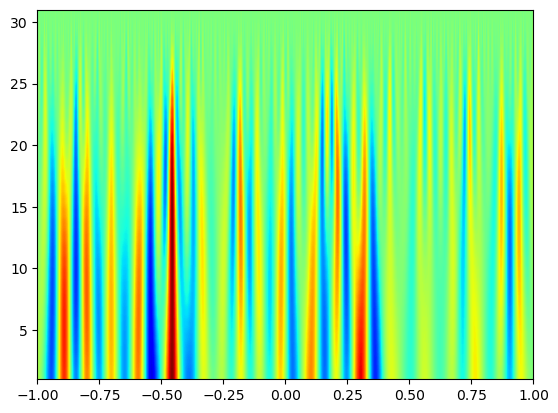

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef) # doctest: +SKIP
plt.show() # doctest: +SKIP

import pywt
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(inte, widths, 'mexh')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='jet', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP

In [ ]:
# Filtro taglia banda
def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    i, u = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(i, u, data)
    return y

# Filtro taglia banda, passa alta
def butter_highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.lfilter(b, a, data)
    return y

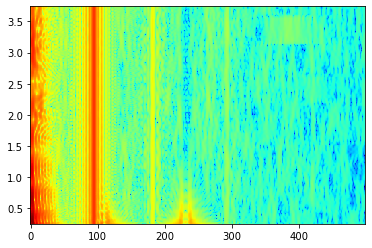

In [ ]:
lowcut=117
highcut=123
fs=500

y=butter_bandstop_filter(sz_win[1][0], lowcut, highcut, fs, order=6)
lowcut=57
highcut=63
y=butter_bandstop_filter(y, lowcut, highcut, fs, order=6)

cutoff=1
y=butter_highpass_filter(y, cutoff, fs, order=6)

freqs, bins,Pxx =signal.spectrogram(np.array(y), nfft=1024, fs=500, return_onesided=True, noverlap=250)
Pxx = np.delete(Pxx, np.s_[117:123+1], axis=0)
Pxx = np.delete(Pxx, np.s_[57:63+1], axis=0)
Pxx = np.delete(Pxx, 0, axis=0)
freqs = np.arange(Pxx.shape[0])
result=(10*np.log10(np.transpose(Pxx))-(10*np.log10(np.transpose(Pxx))).min())/(10*np.log10(np.transpose(Pxx))).ptp()
plt.pcolormesh(freqs, bins, result,cmap=plt.cm.jet)